## Imports

In [301]:
import yfinance as yf 
import pandas as pd
import sqlite3
from configparser import ConfigParser
import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BusinessDay
import holidays
import matplotlib

## 1 - First version

In [ ]:
# month_symbol_mapper = {
#     'jul':'N',
#     'aug':'Q',
#     'sep':'U',
#     'oct':'V',
#     'nov':'X',
#     'dec':'Z',
#     'jan':'F',
#     'feb':'G',
#     'mar':'H',
#     'apr':'J',
#     'may':'K',
#     'jun':'M',
# }

# def oil_futures_ticker_generator(year='22',month='jan'):
#     ticker =  f"CL{month_symbol_mapper[month]}{year}.NYM"
#     print(ticker)
#     return ticker

# def get_yahoo_data(ticker="CLN22.NYM",start=None,end=None):
#     yahoo_ticker_interface = yf.Ticker(ticker)
#     if start is None or end is None:        
#         price_data = yahoo_ticker_interface.history(period='max')
#     else:
#         price_data = yahoo_ticker_interface.history(start=start,end=end)
#     price_data.drop(labels=['Dividends','Stock Splits'], axis=1, inplace=True)
#     price_data['Ticker']=ticker
#     return price_data

# def get_front_month():
#     month_string = datetime.datetime(datetime.date.today().year,datetime.date.today().month+2,1).strftime('%b').lower()
#     month_number = datetime.datetime(datetime.date.today().year,datetime.date.today().month+2,1).strftime('%-m')
#     return {'month_string': month_string, 'month_number':month_number}

# def get_back_month():
#     month_string = datetime.datetime(datetime.date.today().year,datetime.date.today().month+3,1).strftime('%b').lower()
#     month_number = datetime.datetime(datetime.date.today().year,datetime.date.today().month+3,1).strftime('%-m')
#     return {'month_string': month_string, 'month_number':month_number}

# def get_current_cycle():
#     cycle_start = datetime.datetime(datetime.date.today().year,datetime.date.today().month,1)
#     today = datetime.date.today()
#     return {'cycle_start':cycle_start, 'today':today}


In [ ]:
# front_month = get_front_month()
# back_month = get_back_month()
# front_month_ticker = oil_futures_ticker_generator(month= front_month['month_string'])
# back_month_ticker = oil_futures_ticker_generator(month= back_month['month_string'])
# current_cycle = get_current_cycle()
# front_month_data = get_yahoo_data(ticker=front_month_ticker,start=current_cycle['cycle_start'],end=current_cycle['today'])
# back_month_data = get_yahoo_data(ticker=back_month_ticker,start=current_cycle['cycle_start'],end=current_cycle['today'])
# front_month_data.head()
# back_month_data.head()

In [ ]:
# merged = pd.merge(front_month_data, back_month_data, left_index=True, right_index=True, how='inner', suffixes=('_front','_back'))
# merged['Time_Spread']= merged['Close_back']-merged['Close_front']
# merged

In [ ]:
# oil = yf.Ticker("CLN22.NYM")
# #oil.history(start=datetime.datetime(datetime.date.today().year,datetime.date.today().month-2,1))

# oil = get_yahoo_data(ticker="CLN22.NYM", start=datetime.datetime(datetime.date.today().year,datetime.date.today().month-2,1), end=datetime.datetime.now())
# oil
# # ticker = oil_futures_ticker_generator(year='22',month='jul')
# # hist['ticker']=ticker
# # hist.head()
# # hist.index

In [ ]:
# datetime.datetime(datetime.date.today().year,datetime.date.today().month,1)
# #datetime.datetime(datetime.date.today().year,datetime.date.today().month+3,1).strftime('%h').lower()
# #datetime.date.today().strftime('%b').lower()
# # datetime.datetime.now()
# #datetime.datetime(datetime.date.today().year,datetime.date.today().month+2,1).strftime('%-m')

## 2- Database connectivity

In [ ]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Exception as e:
        print(e)

    return conn

In [ ]:
conn = create_connection('futures.db')
cur = conn.cursor()
cur.execute("SELECT TICKER, MAX(DATE) FROM OIL_FUTURES_YAHOO WHERE TICKER = 'CLU22.NYM' GROUP BY TICKER")
res = cur.fetchone()
print(type(res))
print(res)
print(type(res[0][1]))
datetime_obj = datetime.datetime.strptime(res[1], '%Y-%m-%d')
print(datetime_obj)
print(type(datetime_obj))
if datetime_obj <= datetime.datetime.now():
    print('True')
else:
    print('False')


In [ ]:
def create_entry(conn, row):
    """
    Create a new futures price entry in the database's OIL_FUTURES_YAHOO table
    :param conn:
    :param row:
    :return: void
    """
    sql = '''INSERT INTO OIL_FUTURES_YAHOO(TICKER, DATE, OPEN, HIGH, LOW, CLOSE, VOLUME)
            VALUES(?,?,?,?,?,?,?)'''
    try:
        cur = conn.cursor()
        cur.execute(sql,row)
        conn.commit()
    except Exception as e:
        print(e)

In [ ]:
for index,row in back_month_data.iterrows():
    print((row[5],index.date(),row[0],row[1],row[2],row[3],row[4]))
    row = (row[5],index.date(),row[0],row[1],row[2],row[3],row[4])
    create_entry(conn, row)


## 3- Creating a class

In [71]:

config_object = ConfigParser()
config_object.read("config.ini")
server_config = config_object["SERVERINFO"]



month_symbol_mapper = {
    '1':{'string':'jan','code':'F'},
    '2':{'string':'feb','code':'G'},
    '3':{'string':'mar','code':'H'},
    '4':{'string':'apr','code':'J'},
    '5':{'string':'may','code':'K'},
    '6':{'string':'jun','code':'M'},
    '7':{'string':'jul','code':'N'},
    '8':{'string':'aug','code':'Q'},
    '9':{'string':'sep','code':'U'},
    '10':{'string':'oct','code':'V'},
    '11':{'string':'nov','code':'X'},
    '12':{'string':'dev','code':'Z'},
}

class yahoo_futures_interface:
    def __init__(self, year='22', month='1'):
        self.year = year
        self.month = month

    def _oil_futures_ticker_generator(self):
        self.ticker = f"CL{month_symbol_mapper[self.month]['code']}{self.year}.NYM"
        print(self.ticker)

    def get_yahoo_data(self, start=None):
        self._oil_futures_ticker_generator()
        self._get_start_date()
        yahoo_ticker_interface = yf.Ticker(self.ticker)
        self.price_data = yahoo_ticker_interface.history(
                start=self.start_date, end=datetime.datetime.now())
        self.price_data.drop(
            labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
        self.price_data['Ticker'] = self.ticker
        self.price_data['Ticker'] = self.ticker
    
    def _get_start_date(self):
        self._create_connection()
        self.cur.execute(f"SELECT MAX(DATE) FROM OIL_FUTURES_YAHOO WHERE TICKER = '{self.ticker+'i'}';")
        res = self.cur.fetchone()
        self.conn.close()
        print(res)
        if res[0] is not None :
            self.start_date = datetime.datetime.strptime(res[0], '%Y-%m-%d')
        else:
            self.start_date = datetime.datetime.now() - datetime.timedelta(45)
        print(self.start_date)


    def _create_connection(self, db_file=server_config['database']):
        """ create a database connection to the SQLite database
            specified by db_file
        :param db_file: database file
        :return: Connection object or None
        """
        self.conn = None
        try:
            self.conn = sqlite3.connect(db_file)
            self.cur = self.conn.cursor()
        except Exception as e:
            print(e)
    
    
    def _create_execute_entry(self, row):
        """
        Create a new futures price entry in the database's OIL_FUTURES_YAHOO table
        :param conn:
        :param row:
        :return: void
        """
        
        sql = '''INSERT INTO OIL_FUTURES_YAHOO(TICKER, DATE, OPEN, HIGH, LOW, CLOSE, VOLUME)
                VALUES(?,?,?,?,?,?,?)'''
        try:
            self._create_connection()
            self.cur.execute(sql,row)
            self.conn.commit()
            self.conn.close()
        except Exception as e:
            print(e)
    
    def create_entries_from_dataframe(self):
        #self._create_connection()
        for index,row in self.price_data.iterrows():
            print((row[5],index.date(),row[0],row[1],row[2],row[3],row[4]))
            row = (row[5],index.date(),row[0],row[1],row[2],row[3],row[4])
            self._create_execute_entry(row)
        


In [9]:
# sep = yahoo_futures_interface(year='22', month='9')
# sep.get_yahoo_data()
# sep.price_data
# sep.create_entries_from_dataframe()

In [ ]:
# for contract in next_12_contracts:
#     print(f"year: {contract['year']}, month: {contract['month']}")
#     interface = yahoo_futures_interface(year='22', month='9')
#     interface.get_yahoo_data()
#     interface.create_entries_from_dataframe()


In [ ]:
from dateutil.relativedelta import relativedelta
def get_next_12_contract_months(month_symbol_mapper):
    year  = datetime.date.today().year
    month = datetime.date.today().month +2
    next_12_contracts = []
    step=0
    while step < 12:
        #print(f"step: {step}, month: {month}, year: {year}")
        if month < 12:
            next_12_contracts.append({'year':str(year), 'month':str(month)})
            month +=1
        else:
            next_12_contracts.append({'year':str(year), 'month':str(month)})
            year+=1
            month = 1
            
        step+=1
    return next_12_contracts


next_12_contracts = get_next_12_contract_months(month_symbol_mapper)
## get  3 business days from date
from pandas.tseries.offsets import *
contract_exprations = []
for contract in next_12_contracts:
    #pass
    #print(contract)
    year = int(contract['year'])
    month = int(contract['month'])

    previous_month_25th_day = datetime.date(year,month,25) - relativedelta(months=1)
    
    if previous_month_25th_day.weekday() < 5:
        contract_expiration = previous_month_25th_day-3*BusinessDay()
    else:
        contract_expiration = previous_month_25th_day-4*BusinessDay()
    print(f"contract:{year}-{month}, prev 25th : {previous_month_25th_day}, expiry : {contract_expiration.date().strftime('%m-%d')}")
    contract_exprations.append([f"{month}", contract_expiration.date().strftime('%m-%d')])
for i in contract_exprations:
    print(i)

    # if datetime.datetime(int(contract['year']),max(1,int(contract['month'])-1),25).weekday() <5:
    #     
    # else:
    #     print(datetime.datetime(int(contract['year']),max(1,int(contract['month'])-1),25)-4*BusinessDay())

In [1]:
import yfinance as yf
import sqlite3
#from yf_interface.base import yahoo_futures_interface
from configparser import ConfigParser
import datetime
from pandas.tseries.offsets import BusinessDay
from dateutil.relativedelta import relativedelta

#SETUP CONFIG OBJECT
config_object = ConfigParser()
config_object.read("config.ini")
server_config = config_object["SERVERINFO"]



month_symbol_mapper = {
    '1':{'string':'jan','code':'F'},
    '2':{'string':'feb','code':'G'},
    '3':{'string':'mar','code':'H'},
    '4':{'string':'apr','code':'J'},
    '5':{'string':'may','code':'K'},
    '6':{'string':'jun','code':'M'},
    '7':{'string':'jul','code':'N'},
    '8':{'string':'aug','code':'Q'},
    '9':{'string':'sep','code':'U'},
    '10':{'string':'oct','code':'V'},
    '11':{'string':'nov','code':'X'},
    '12':{'string':'dev','code':'Z'},
}

class yahoo_futures_interface:
    def __init__(self, year='22', month='1'):
        self.year = year
        self.month = month

    def _oil_futures_ticker_generator(self):
        self.ticker = f"CL{month_symbol_mapper[self.month]['code']}{self.year}.NYM"
        print(self.ticker)

    def get_yahoo_data(self, start=None):
        self._oil_futures_ticker_generator()
        self._get_start_date()
        self._get_settlement_date()
        yahoo_ticker_interface = yf.Ticker(self.ticker)
        self.price_data = yahoo_ticker_interface.history(
                start=self.start_date, end=datetime.datetime.now())
        try:
            self.price_data.drop(
            labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
        except Exception as e:
            print(e)
        self.price_data['Ticker'] = self.ticker
        self.price_data['Settlement Date'] = self.contract_expiration 
    
    def _get_start_date(self):
        self._create_connection()
        self.cur.execute(f"SELECT MAX(DATE) FROM OIL_FUTURES_YAHOO WHERE TICKER = '{self.ticker+'i'}';")
        res = self.cur.fetchone()
        self.conn.close()
        print(res)
        if res[0] is not None :
            self.start_date = datetime.datetime.strptime(res[0], '%Y-%m-%d')
        else:
            self.start_date = datetime.datetime.now() - datetime.timedelta(45)
        print(self.start_date)


    def _create_connection(self, db_file=server_config['database']):
        """ create a database connection to the SQLite database
            specified by db_file
        :param db_file: database file
        :return: Connection object or None
        """
        self.conn = None
        try:
            self.conn = sqlite3.connect(db_file)
            self.cur = self.conn.cursor()
        except Exception as e:
            print(e)
    
    def _get_settlement_date(self):
        year = int(self.year)+2000
        month = int(self.month)

        previous_month_25th_day = datetime.date(year,month,25) - relativedelta(months=1)
        print(f'previous_month_25th_day; {previous_month_25th_day}')
        if previous_month_25th_day.weekday() < 5:
            contract_expiration = previous_month_25th_day-3*BusinessDay()
        else:
            contract_expiration = previous_month_25th_day-4*BusinessDay()
        self.contract_expiration = contract_expiration
    
    
    def _create_execute_entry(self, row):
        """
        Create a new futures price entry in the database's OIL_FUTURES_YAHOO table
        :param conn:
        :param row:
        :return: void
        """
        
        sql = '''INSERT INTO OIL_FUTURES_YAHOO(DATE,TICKER,SETTLEMENT_DATE,OPEN, HIGH, LOW, CLOSE, VOLUME)
                VALUES(?,?,?,?,?,?,?,?)'''
        try:
            self._create_connection()
            self.cur.execute(sql,row)
            self.conn.commit()
            self.conn.close()
        except Exception as e:
            print(e)
    
    def create_entries_from_dataframe(self):
        #self._create_connection()
        for index,row in self.price_data.iterrows():
            print(index.date(),row[5],row[6],row[0],row[1],row[2],row[3],row[4])
            row = (index.date(),row[5],row[6],row[0],row[1],row[2],row[3],row[4])
            self._create_execute_entry(row)
        
def get_next_12_contract_months(month_symbol_mapper):
    year  = datetime.date.today().year-2000
    month = datetime.date.today().month +2
    next_12_contracts = []
    step=0
    while step < 12:
        next_12_contracts.append({'year':str(year), 'month':str(month)})
        if month <12:
            month +=1
        else:
            year+=1
            month = 1
        step+=1
    return next_12_contracts

In [3]:
next_12_contracts = get_next_12_contract_months(month_symbol_mapper)
for contract in [next_12_contracts[0]]:
    print(f"year: {contract['year']}, month: {contract['month']}")
    interface = yahoo_futures_interface(year=contract['year'], month=contract['month'])
    interface.get_yahoo_data()
    #interface.create_entries_from_dataframe()

year: 22, month: 7
CLN22.NYM
(None,)
2022-04-13 14:29:10.156721
previous_month_25th_day; 2022-06-25


In [16]:
datetime.datetime.today().weekday()

5

## 4- Next Settlement Date



### 4.1 Given any datetime.date object, what is the nex_settlment date?

In [77]:
def get_25th_day(date):
    assert  isinstance(date, datetime.date), 'date passed is not a datetime object'
    return datetime.date(date.year, date.month, 25)


def get_business_date_offset(date):
    """Get the settlement date for WTI oil futures using the specs from ICE. 
    The contracts settle 3 business days prior to the 25th of each month. 
    If the 25th is not a business date itself the offset is 4 business days.
    Input: datetime object with the day being the 25th of a given month
    Output: datetime with appropriate offset.
    """
    offset = 3 if date.weekday() < 5 else 4
    return offset


def next_settelment_date(date=datetime.date.today()):
    day_25th = get_25th_day(date)
    business_day_offset = get_business_date_offset(day_25th)
    next_settelment_date = day_25th -  business_day_offset*BusinessDay()
    next_settelment_date = next_settelment_date.to_pydatetime().date()

    if date < next_settelment_date:
        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        return next_settelment_date.date()
    else:
        day_25th = day_25th + relativedelta(months=1)
        business_day_offset = get_business_date_offset(day_25th)
        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        next_settelment_date = next_settelment_date.to_pydatetime().date()
        return next_settelment_date







    

#### scratch

In [82]:
## SCRATCH

# PLAY AROUND WITH DATES
#datetime.date(2022,5,28).day
today = datetime.date.today()

# #TEST FUNCITON get_25th_day
# print(get_25th_day(datetime.date(2022,6,1)))

# # TEST FUNCTION
# print(f"next_settelment_date(date=datetime.date.today()) : {next_settelment_date(date=datetime.date.today())}")

# print(f"next_settelment_date(datetime.date(2022,6,22)) : {next_settelment_date(datetime.date(2022,6,22))}")

# print(f"next_settelment_date(datetime.date(2022,6,17)) : {next_settelment_date(datetime.date(2022,6,17))}")

## 5- Contract code given expiry spread and date

### 5.1- given a date and given number of months spead which contract is the right one for expiry?

In [314]:
def get_contract_code_time_spread(date=datetime.date.today(), time_spread=0):
    print(f"0 date : {date}, of type {type(date)}")
    
    day_25th = get_25th_day(date) + relativedelta(months=time_spread)
    print(f"1 day_25th : {day_25th}, of type {type(day_25th)}")

    business_day_offset = get_business_date_offset(day_25th)
    print(f"2 business_day_offset : {business_day_offset}, of type {type(business_day_offset)}")

    settlement_date_current_month = day_25th -  business_day_offset*BusinessDay()
    print(f"3 settlement_date_current_month : {settlement_date_current_month}, of type {type(settlement_date_current_month)}")

    settlement_date_current_month = settlement_date_current_month.to_pydatetime().date()
    print(f"4 settlement_date_current_month : {settlement_date_current_month}, of type {type(settlement_date_current_month)}")

    if date < settlement_date_current_month:
        next_settelment_date = settlement_date_current_month
        print(f"5 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")
        
    else:
        day_25th = day_25th + relativedelta(months=1)
        print(f"7 day_25th : {day_25th}, of type {type(day_25th)}")

        business_day_offset = get_business_date_offset(day_25th)
        print(f"8 business_day_offset : {business_day_offset}, of type {type(business_day_offset)}")

        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        print(f"9 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")

        next_settelment_date = next_settelment_date.to_pydatetime().date()
        print(f"10 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")
    return next_settelment_date

    

#### scratch

In [315]:
## TESTING get_contract_code_time_spread
#try with default values, today with no spread
front_month = get_contract_code_time_spread()
print(f"11 front_month : {front_month}, of type {type(front_month)}")

# #try with 1 month spread
# get_contract_code_time_spread(time_spread = 1)

# #try with date object in the future
# get_contract_code_time_spread(date = datetime.date(2022, 6, 30))

# #try with date object in the past
# get_contract_code_time_spread(date = datetime.date(2022, 5, 3))

# # try with date object in the past with a spread of 2 month
# get_contract_code_time_spread(date = datetime.date(2022, 5, 3), time_spread=2)

# #try with 1 month spread
spread_month = get_contract_code_time_spread(date = front_month, time_spread = 2)

0 date : 2022-05-30, of type <class 'datetime.date'>
1 day_25th : 2022-05-25, of type <class 'datetime.date'>
2 business_day_offset : 3, of type <class 'int'>
3 settlement_date_current_month : 2022-05-20 00:00:00, of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>
4 settlement_date_current_month : 2022-05-20, of type <class 'datetime.date'>
7 day_25th : 2022-06-25, of type <class 'datetime.date'>
8 business_day_offset : 4, of type <class 'int'>
9 next_settelment_date : 2022-06-21 00:00:00, of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>
10 next_settelment_date : 2022-06-21, of type <class 'datetime.date'>
11 front_month : 2022-06-21, of type <class 'datetime.date'>
0 date : 2022-06-21, of type <class 'datetime.date'>
1 day_25th : 2022-08-25, of type <class 'datetime.date'>
2 business_day_offset : 3, of type <class 'int'>
3 settlement_date_current_month : 2022-08-22 00:00:00, of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>
4 settlement_date_current_month : 

In [97]:
## TESTING RELATTIVE DELTA FUNCTION

#try with a may 31st with a 1 month relative delta knowing that June 31st doesn't exist
date  = datetime.date(2022, 5, 31)
date = date + relativedelta(months=1)
print(date)

#try with a feb 28th with a 1 month relative delta knowing that march 31st does exist
date  = datetime.date(2022, 2, 28)
date = date + relativedelta(months=1)
print(date)

2022-06-30
2022-03-28


In [313]:
## testing dates of expiry with an iteration over number of months ahead

def get_contract_code_time_spread(date=datetime.date.today(), time_spread=0):

    day_25th = get_25th_day(date) + relativedelta(months=time_spread)
    business_day_offset = get_business_date_offset(day_25th)
    settlement_date_current_month = day_25th -  business_day_offset*BusinessDay()
    settlement_date_current_month = settlement_date_current_month.to_pydatetime().date()
    if date < settlement_date_current_month:
        next_settelment_date = settlement_date_current_month
    
    else:
        day_25th = day_25th + relativedelta(months=1)
        business_day_offset = get_business_date_offset(day_25th)
        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        next_settelment_date = next_settelment_date.to_pydatetime().date()
    print(f"1 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")
    #print(f"2 time_spread : {time_spread}, of type {type(time_spread)}")
    return next_settelment_date
    
next_settelment_date = get_contract_code_time_spread()
for step in range(1,15):
    get_contract_code_time_spread(date = next_settelment_date, time_spread = step)

1 next_settelment_date : 2022-06-21, of type <class 'datetime.date'>
1 next_settelment_date : 2022-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-08-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-09-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-10-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-11-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-12-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-01-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-02-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-03-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-04-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-05-22, of type <class 'datetime.date'>
1 next_settelment_date : 2023-06-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-08-2

### 5.2 augment the function get_business_date_offset to use the holidays library to fix issue with Nov 25th not being detected as Thanksgiving 

In [181]:
def get_business_date_offset(date):
    us_holidays = holidays.US()
    """Get the settlement date for WTI oil futures using the specs from ICE. 
    The contracts settle 3 business days prior to the 25th of each month. 
    If the 25th is not a business date itself the offset is 4 business days.
    Input: datetime object with the day being the 25th of a given month
    Output: datetime with appropriate offset.
    """
    offset = 3 if date.weekday() < 5 and date not in us_holidays else 4
    return offset

#### scratch

In [182]:
# # testing if holidays package recognizes new years
# us_holidays = holidays.US()
# datetime.date(2015, 1, 1) in us_holidays
# datetime.date(2022, 11, 22) in us_holidays

# testing if the business offset will recognise thanksgiving 2022
print(get_business_date_offset(datetime.date(2022, 11, 24)))


4


In [174]:
#inspect the holiday calendar
for holiday in holidays.US(years=[2022]).items():
    print(holiday)

(datetime.date(2022, 1, 1), "New Year's Day")
(datetime.date(2022, 1, 17), 'Martin Luther King Jr. Day')
(datetime.date(2022, 2, 21), "Washington's Birthday")
(datetime.date(2022, 5, 30), 'Memorial Day')
(datetime.date(2022, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2022, 6, 20), 'Juneteenth National Independence Day (Observed)')
(datetime.date(2022, 7, 4), 'Independence Day')
(datetime.date(2022, 9, 5), 'Labor Day')
(datetime.date(2022, 10, 10), 'Columbus Day')
(datetime.date(2022, 11, 11), 'Veterans Day')
(datetime.date(2022, 11, 24), 'Thanksgiving')
(datetime.date(2022, 12, 25), 'Christmas Day')
(datetime.date(2022, 12, 26), 'Christmas Day (Observed)')


In [317]:
## testing dates of expiry with an iteration over number of months ahead, having included the US holiday in function get_business_date_offset()

def get_contract_code_time_spread(date=datetime.date.today(), time_spread=0):

    day_25th = get_25th_day(date) + relativedelta(months=time_spread)
    business_day_offset = get_business_date_offset(day_25th)
    settlement_date_current_month = day_25th -  business_day_offset*BusinessDay()
    settlement_date_current_month = settlement_date_current_month.to_pydatetime().date()
    if date < settlement_date_current_month:
        next_settelment_date = settlement_date_current_month
    
    else:
        day_25th = day_25th + relativedelta(months=1)
        business_day_offset = get_business_date_offset(day_25th)
        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        next_settelment_date = next_settelment_date.to_pydatetime().date()
    print(f"1 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")
    #print(f"2 time_spread : {time_spread}, of type {type(time_spread)}")
    return next_settelment_date
    
next_settelment_date = get_contract_code_time_spread()
for step in range(1,15):
    get_contract_code_time_spread(date = next_settelment_date, time_spread = step)

1 next_settelment_date : 2022-06-21, of type <class 'datetime.date'>
1 next_settelment_date : 2022-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-08-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-09-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-10-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-11-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-12-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-01-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-02-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-03-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-04-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-05-22, of type <class 'datetime.date'>
1 next_settelment_date : 2023-06-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-08-2

In [319]:
#test with starting increment is 0
for step in range(0,15):
    if step ==0:
        next_settelment_date = get_contract_code_time_spread()
    else:
        next_settelment_date = get_contract_code_time_spread(date = next_settelment_date, time_spread = 1)

1 next_settelment_date : 2022-06-21, of type <class 'datetime.date'>
1 next_settelment_date : 2022-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-08-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-09-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-10-20, of type <class 'datetime.date'>
1 next_settelment_date : 2022-11-22, of type <class 'datetime.date'>
1 next_settelment_date : 2022-12-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-01-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-02-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-03-21, of type <class 'datetime.date'>
1 next_settelment_date : 2023-04-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-05-22, of type <class 'datetime.date'>
1 next_settelment_date : 2023-06-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-07-20, of type <class 'datetime.date'>
1 next_settelment_date : 2023-08-2

### 5.3 get settlement date as well as contract code 

In [320]:
month_symbol_mapper = {
    '1':{'string':'jan','code':'F'},
    '2':{'string':'feb','code':'G'},
    '3':{'string':'mar','code':'H'},
    '4':{'string':'apr','code':'J'},
    '5':{'string':'may','code':'K'},
    '6':{'string':'jun','code':'M'},
    '7':{'string':'jul','code':'N'},
    '8':{'string':'aug','code':'Q'},
    '9':{'string':'sep','code':'U'},
    '10':{'string':'oct','code':'V'},
    '11':{'string':'nov','code':'X'},
    '12':{'string':'dev','code':'Z'},
}


def oil_futures_ticker_generator(date):
        ticker = f"CL{month_symbol_mapper[str(date.month)]['code']}{date.year-2000}.NYM"
        return ticker


def get_contract_code_time_spread(date=datetime.date.today(), time_spread=0):

    day_25th = get_25th_day(date) + relativedelta(months=time_spread)
    business_day_offset = get_business_date_offset(day_25th)
    settlement_date_current_month = day_25th -  business_day_offset*BusinessDay()
    settlement_date_current_month = settlement_date_current_month.to_pydatetime().date()
    if date < settlement_date_current_month:
        next_settelment_date = settlement_date_current_month
    
    else:
        day_25th = day_25th + relativedelta(months=1)
        business_day_offset = get_business_date_offset(day_25th)
        next_settelment_date = day_25th - business_day_offset*BusinessDay()
        next_settelment_date = next_settelment_date.to_pydatetime().date()
    #print(f"1 next_settelment_date : {next_settelment_date}, of type {type(next_settelment_date)}")
    ticker = oil_futures_ticker_generator(next_settelment_date+relativedelta(months=1))

    print(f"2 next_settelment_date : {next_settelment_date}, ticker: {ticker}")
    return ticker, next_settelment_date






for step in [0,3,6,9,12]:
    if step ==0:
        ticker, front_settelment_date = get_contract_code_time_spread()
    else:
        ticker, next_settelment_date = get_contract_code_time_spread(date = front_settelment_date, time_spread = step)

2 next_settelment_date : 2022-06-21, ticker: CLN22.NYM
2 next_settelment_date : 2022-09-20, ticker: CLV22.NYM
2 next_settelment_date : 2022-12-20, ticker: CLF23.NYM
2 next_settelment_date : 2023-03-21, ticker: CLJ23.NYM
2 next_settelment_date : 2023-06-20, ticker: CLN23.NYM


## 6- compute timespreads

In [195]:
#connect to database
conn = sqlite3.connect('futures.db')
cur = conn.cursor()

sql = '''SELECT MIN(DATE) FROM OIL_FUTURES_YAHOO'''
cur.execute(sql)
res = cur.fetchone()




2022-04-12


datetime.date(2022, 4, 12)

### SCRATCH

In [212]:
#verify if you can build a datetime object from the result of the query
sql = '''SELECT MIN(DATE) FROM OIL_FUTURES_YAHOO'''
cur.execute(sql)
min_date = cur.fetchone()
print(min_date[0])


min_date = datetime.datetime.strptime(min_date[0], '%Y-%m-%d').date()

2022-04-12


In [216]:
#iterate over date using relativedelta and pull data from database
start_date = datetime.datetime.strptime(str(min_date), '%Y-%m-%d').date()
today = datetime.date.today()
step = 0
while start_date < today and step < 5:
    print(f"start_date: {start_date} of type {type(start_date)}")
    start_date = start_date + relativedelta(days=1)
    step += 1

start_date: 2022-04-12 of type <class 'datetime.date'>
start_date: 2022-04-13 of type <class 'datetime.date'>
start_date: 2022-04-14 of type <class 'datetime.date'>
start_date: 2022-04-15 of type <class 'datetime.date'>
start_date: 2022-04-16 of type <class 'datetime.date'>


In [222]:
#verify that you can query the database using the date objects that you generated above
print(f"start_date: {str(min_date)} of type {type(str(min_date))}")
start_date = datetime.datetime.strptime(str(min_date), '%Y-%m-%d').date()
sql = f"""SELECT * FROM OIL_FUTURES_YAHOO WHERE DATE = '{start_date}'"""
cur.execute(sql)
res = cur.fetchone()
print(res)

start_date: 2022-04-12 of type <class 'str'>
('CLN22.NYM', '2022-04-12', 94.45999908447266, 100.02999877929688, 94.05999755859375, 99.4000015258789, 95008, '2022-06-21')


In [236]:
# # fetch data from the database using the timespreads and tickers
# ticker, next_settelment_date = get_contract_code_time_spread()
for step in [0,3,6,9,12]:
    if step==0:
        ticker, next_settelment_date = get_contract_code_time_spread()
    else:
        ticker, next_settelment_date = get_contract_code_time_spread(date = next_settelment_date, time_spread = step)


2 next_settelment_date : 2022-06-21, ticker: CLN2022.NYM
2 next_settelment_date : 2022-09-20, ticker: CLV2022.NYM
2 next_settelment_date : 2023-03-21, ticker: CLJ2023.NYM
2 next_settelment_date : 2023-12-19, ticker: CLF2024.NYM
2 next_settelment_date : 2024-12-19, ticker: CLF2025.NYM


In [247]:
ticker_0, next_settelment_date_0 = get_contract_code_time_spread()
ticker_3, next_settelment_date_3 = get_contract_code_time_spread(date = next_settelment_date_0, time_spread = 3)
ticker_6, next_settelment_date_6 = get_contract_code_time_spread(date = next_settelment_date_3, time_spread = 3)
ticker_9, next_settelment_date_9 = get_contract_code_time_spread(date = next_settelment_date_6, time_spread = 3)
ticker_12, next_settelment_date_12 = get_contract_code_time_spread(date = next_settelment_date_9, time_spread = 3)

2 next_settelment_date : 2022-06-21, ticker: CLN22.NYM
2 next_settelment_date : 2022-09-20, ticker: CLV22.NYM
2 next_settelment_date : 2022-12-20, ticker: CLF23.NYM
2 next_settelment_date : 2023-03-21, ticker: CLJ23.NYM
2 next_settelment_date : 2023-06-20, ticker: CLN23.NYM


In [298]:
# GET MAX DATE FROM THE SPREADS TABLE
conn = sqlite3.connect('futures.db')
cur = conn.cursor()
sql= """
SELECT MAX(DATE)
FROM OIL_FUTURES_CL_TIME_SPREADS
"""
cur.execute(sql)
max_spread_date = cur.fetchone()
max_spread_date = max_spread_date[0]
print(max_spread_date, type(max_spread_date[0]))
conn.close()

2022-05-27 <class 'str'>


In [293]:
# CREATE AN SQL THAT JOINS A BUNCH OF TEMP TABLES, EACH FOR A DISTINCT EXPIRY DATE, AND JOIN THE ON THE DATE KEY

conn = sqlite3.connect('futures.db')
cur = conn.cursor()

sql = f"""
WITH TEMP_0 AS (
    SELECT DATE, TICKER, CLOSE
    FROM OIL_FUTURES_YAHOO
    WHERE TICKER = '{ticker_0}'

),
TEMP_3 AS (
    SELECT DATE, TICKER, CLOSE
    FROM OIL_FUTURES_YAHOO
    WHERE TICKER = '{ticker_3}'

),
TEMP_6 AS (
    SELECT DATE, TICKER, CLOSE
    FROM OIL_FUTURES_YAHOO
    WHERE TICKER = '{ticker_6}'

),
TEMP_9 AS (
    SELECT DATE, TICKER, CLOSE
    FROM OIL_FUTURES_YAHOO
    WHERE TICKER = '{ticker_9}'

),
TEMP_12 AS (
    SELECT DATE, TICKER, CLOSE
    FROM OIL_FUTURES_YAHOO
    WHERE TICKER = '{ticker_12}'

)
SELECT 
    TEMP_0.DATE, TEMP_0.TICKER SPR_FRONT_CONTRACT, TEMP_0.CLOSE SPR_FRONT_CLOSING,
    TEMP_3.TICKER SPR_3MO_CONTRACT, TEMP_3.CLOSE SPR_3MO_CLOSING,
    TEMP_6.TICKER SPR_6MO_CONTRACT, TEMP_6.CLOSE SPR_6MO_CLOSING,
    TEMP_9.TICKER SPR_9MO_CONTRACT, TEMP_9.CLOSE SPR_9MO_CLOSING,
    TEMP_12.TICKER SPR_12MO_CONTRACT, TEMP_12.CLOSE SPR_12MO_CLOSING
FROM TEMP_0
INNER JOIN TEMP_3
    ON TEMP_0.DATE = TEMP_3.DATE
INNER JOIN TEMP_6
    ON TEMP_0.DATE = TEMP_6.DATE
INNER JOIN TEMP_9
    ON TEMP_0.DATE = TEMP_9.DATE
INNER JOIN TEMP_12
    ON TEMP_0.DATE = TEMP_12.DATE
WHERE TEMP_0.DATE > '{max_spread_date}'
"""
df = pd.read_sql_query(sql, conn)
# cur.execute(sql)
# result = cur.fetchall()
conn.close()
df.head()



,DATE,SPR_FRONT_CONTRACT,SPR_FRONT_CLOSING,SPR_3MO_CONTRACT,SPR_3MO_CLOSING,SPR_6MO_CONTRACT,SPR_6MO_CLOSING,SPR_9MO_CONTRACT,SPR_9MO_CLOSING,SPR_12MO_CONTRACT,SPR_12MO_CLOSING
0,2022-04-14,CLN22.NYM,105.440002,CLV22.NYM,100.970001,CLF23.NYM,97.029999,CLJ23.NYM,93.599998,CLN23.NYM,90.750000
1,2022-04-18,CLN22.NYM,106.410004,CLV22.NYM,101.379997,CLF23.NYM,97.059998,CLJ23.NYM,93.400002,CLN23.NYM,90.470001
2,2022-04-19,CLN22.NYM,101.160004,CLV22.NYM,96.800003,CLF23.NYM,92.570000,CLJ23.NYM,89.080002,CLN23.NYM,86.339996
3,2022-04-20,CLN22.NYM,101.360001,CLV22.NYM,97.279999,CLF23.NYM,93.190002,CLJ23.NYM,89.690002,CLN23.NYM,86.860001
4,2022-04-21,CLN22.NYM,102.959999,CLV22.NYM,98.709999,CLF23.NYM,94.570000,CLJ23.NYM,91.110001,CLN23.NYM,88.320000


In [294]:
## insert values into dataframe
conn = sqlite3.connect('futures.db')
cur = conn.cursor()
try:
    df.to_sql('OIL_FUTURES_CL_TIME_SPREADS', index=False, con= conn, if_exists='append')
except Exception as e :
    print(e)
conn.close()

In [296]:
## get closing data for spread calculation
conn = sqlite3.connect('futures.db')
cur = conn.cursor()

sql = """
SELECT 
    SPR_FRONT_CLOSING,
    SPR_3MO_CLOSING,
    SPR_6MO_CLOSING,
    SPR_9MO_CLOSING,
    SPR_12MO_CLOSING
FROM OIL_FUTURES_CL_TIME_SPREADS
"""

try:
    df = pd.read_sql(sql, con= conn)
except Exception as e :
    print(e)
conn.close()
df.head()

,SPR_FRONT_CLOSING,SPR_3MO_CLOSING,SPR_6MO_CLOSING,SPR_9MO_CLOSING,SPR_12MO_CLOSING
0,105.440002,100.970001,97.029999,93.599998,90.750000
1,106.410004,101.379997,97.059998,93.400002,90.470001
2,101.160004,96.800003,92.570000,89.080002,86.339996
3,101.360001,97.279999,93.190002,89.690002,86.860001
4,102.959999,98.709999,94.570000,91.110001,88.320000


In [299]:
# add columns for timespreads
df['3MO_SPREAD'] = df['SPR_FRONT_CLOSING'] - df['SPR_3MO_CLOSING']
df['6MO_SPREAD'] = df['SPR_FRONT_CLOSING'] - df['SPR_6MO_CLOSING']
df['9MO_SPREAD'] = df['SPR_FRONT_CLOSING'] - df['SPR_9MO_CLOSING']
df['12MO_SPREAD'] = df['SPR_FRONT_CLOSING'] - df['SPR_12MO_CLOSING']
df.head()

,SPR_FRONT_CLOSING,SPR_3MO_CLOSING,SPR_6MO_CLOSING,SPR_9MO_CLOSING,SPR_12MO_CLOSING,3MO_SPREAD,6MO_SPREAD,9MO_SPREAD,12MO_SPREAD
0,105.440002,100.970001,97.029999,93.599998,90.750000,4.470001,8.410004,11.840004,14.690002
1,106.410004,101.379997,97.059998,93.400002,90.470001,5.030006,9.350006,13.010002,15.940002
2,101.160004,96.800003,92.570000,89.080002,86.339996,4.360001,8.590004,12.080002,14.820007
3,101.360001,97.279999,93.190002,89.690002,86.860001,4.080002,8.169998,11.669998,14.500000
4,102.959999,98.709999,94.570000,91.110001,88.320000,4.250000,8.389999,11.849998,14.639999


<AxesSubplot:>

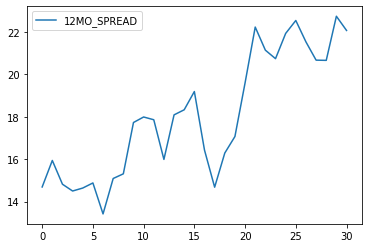

In [305]:
df.plot.line(y='12MO_SPREAD')